# Predicción de diabetes con Árboles de Decisión (Pima Indians Diabetes Dataset)

## 0. Importar librerias

In [383]:
# Data processing
# ==================================================================================
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pickle import dump
import json
import numpy as np

# Charts
# ==================================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
# ==================================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest

# Warnings Configuration
# ==================================================================================
import warnings

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn # ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
'''NOTE: This affects only the display and not the underlying data, which remains unchanged.'''

'NOTE: This affects only the display and not the underlying data, which remains unchanged.'

# 1. Planteamiento del problema y recopilación de datos

## 1.1 Planteamiento de problema

En este proyecto utilizamos el dataset de Pima Indians Diabetes del 
National Institute of Diabetes and Digestive and Kidney Diseases.

**Objetivo:** predecir si un paciente tiene diabetes (`Outcome` = 1) a partir
de variables clínicas como glucosa, presión arterial, insulina, BMI, edad, etc.

## 1.2 Recopilación de datos

In [384]:
pd.options.display.max_columns=None
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


## 1.3 Exploración y limpieza de datos

Información de las variables:

- `Pregnancies`: Número de embarazos de la paciente (numérico).
- `Glucose`: Concentración plasmática de glucosa tras 2 horas de una prueba de tolerancia a la glucosa oral (numérico).
- `BloodPressure`: Presión arterial diastólica (medida en mmHg) (numérico).
- `SkinThickness`: Grosor del pliegue cutáneo tricipital (medido en mm) (numérico).
- `Insulin`: Insulina sérica a las 2 horas (medida en mu U/ml) (numérico).
- `BMI`: Índice de masa corporal (numérico).
- `DiabetesPedigreeFunction`: Función de pedigrí de diabetes (numérico).
- `Age`: Edad de la paciente (numérico).
- `Outcome`: Variable de clase (0 o 1), donde 0 significa diabetes negativa y 1 significa diabetes positiva (numérico).

In [385]:
print(f"Hay {df.shape[0]} filas y {df.shape[1]} columnas")

Hay 768 filas y 9 columnas


In [386]:
# Obtener información sobre tipos de datos y valores no nulos

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [387]:
print(f"Valores unicos por columna: \n{df.nunique()}")

Valores unicos por columna: 
Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64


## Conclusiones:

### No existen valores nulos ni duplicados en el marco de datos, y contamos con características categóricas y numéricas.

## 1.4 Eliminación de información irrelevante y tratamiento de valores nulos

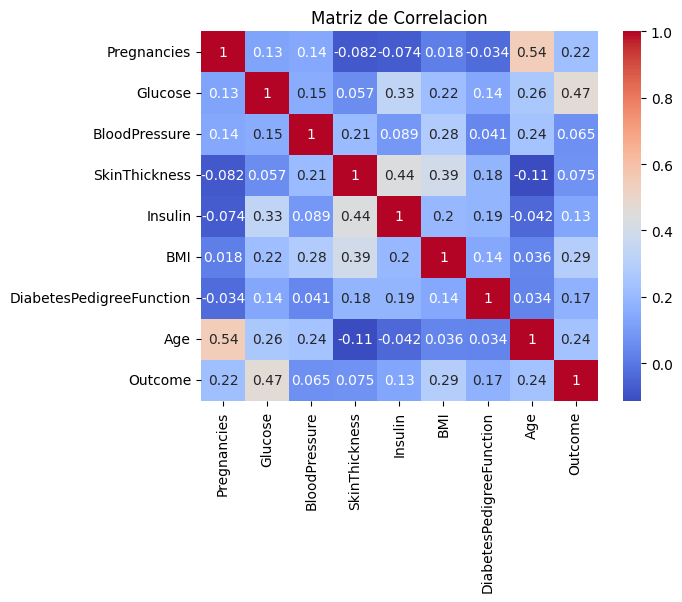

In [388]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlacion")
plt.show()

In [389]:
print(f"Valores nulos por columna: \n{df.isnull().sum()}")

Valores nulos por columna: 
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [390]:
df_eda = df.copy()

num_duplicates = df_eda.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

if num_duplicates > 0:
    df_eda = df_eda.drop_duplicates().reset_index(drop=True)
    print(f"Se han eliminado {num_duplicates} filas duplicadas.")
    print(f"Ahora hay {df_eda.shape[0]} filas.")
else:
    print("No se han encontrado filas duplicadas.")

Número de filas duplicadas: 0
No se han encontrado filas duplicadas.


#### Para este conjunto de datos, conservaremos todas las características, ya que creemos que cada una desempeña un papel importante en la predicción del objetivo.

# 2. Anaalisis de variables Univariante

### Una variable univariante es un término estadístico que se emplea para referenciar un conjunto de observaciones de un atributo. Esto es, el análisis columna a columna del DataFrame. Para ello, debemos distinguir si una variable es categórica o numérica, ya que el cuerpo del análisis y las conclusiones que se pueden obtener serán distintas.

## 2.1 Análisis univariante de variables numéricas:

### Una variable numérica es un tipo de variable que puede tomar valores numéricos (enteros, fracciones, decimales, negativos, etc.) en un rango infinito. Una variable categórica numérica puede ser también una variable numérica (por ejemplo, para los sucesivos análisis, podemos tomar la clase Survived como numérica también para estudiar relaciones). Normalmente se representan utilizando un histograma y diagramas de caja, expuestos juntos.

In [391]:
numerical_var_int = []
numerical_var_float = []

for column in df_eda: 
    if (df_eda[column].dtype == 'int64') :
        numerical_var_int.append(column)
    elif (df_eda[column].dtype == 'float64'):
        numerical_var_float.append(column)

print(f"Variables numericas (int):\n\n{numerical_var_int}\n\nTotal = {len(numerical_var_int)}")
print(f"Variables numericas (float64):\n\n{numerical_var_float}\n\nTotal = {len(numerical_var_float)}")


Variables numericas (int):

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age', 'Outcome']

Total = 7
Variables numericas (float64):

['BMI', 'DiabetesPedigreeFunction']

Total = 2


In [392]:
num_cols = df_eda.select_dtypes(include=["int64", "float64"]).columns.tolist()
print(f"Variables numéricas: {num_cols}")

num_vars = len(num_cols)

Variables numéricas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


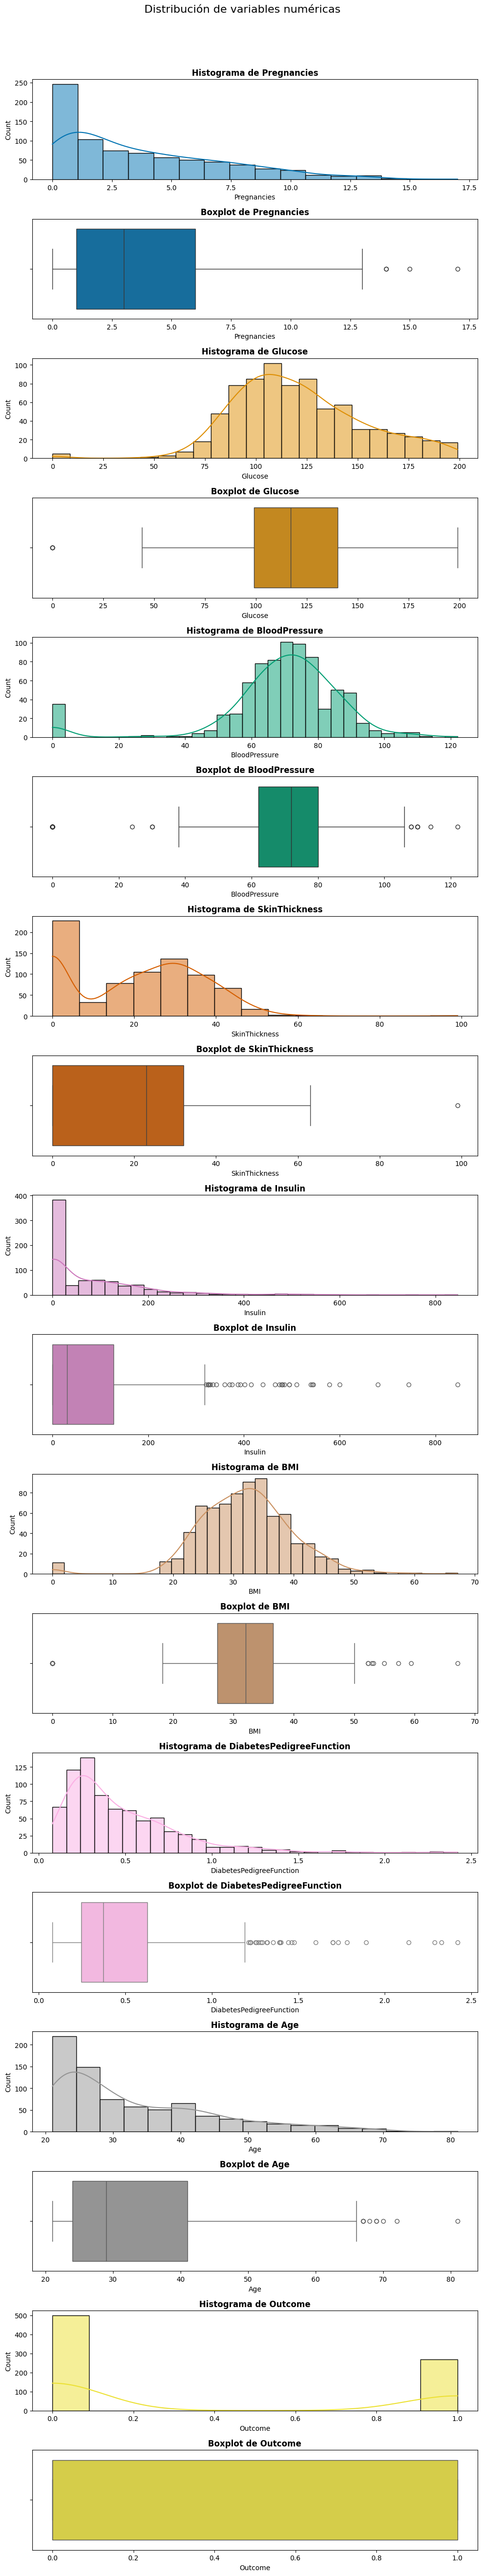

In [393]:
# Figura: 2 filas por variable, 1 columna
fig, axes = plt.subplots(
    nrows=2 * num_vars,
    ncols=1,
    figsize=(10, 3 * 2 * num_vars)  # alto proporcional al nº de variables
)

plt.suptitle('Distribución de variables numéricas', fontsize=16, y=0.995)

# Aseguramos que axes es siempre un array 1D
axes = np.array(axes).flatten()

# Paleta: un color por variable
palette = sns.color_palette("colorblind", num_vars)

for i, col in enumerate(num_cols):
    color = palette[i % len(palette)]
    
    # índice de las filas para esta variable
    idx_hist = i * 2        # fila del histograma
    idx_box  = i * 2 + 1    # fila del boxplot

    # Histograma (arriba)
    sns.histplot(
        data=df_eda,
        x=col,
        kde=True,
        ax=axes[idx_hist],
        color=color
    )
    axes[idx_hist].set_title(f'Histograma de {col}', fontweight='bold')

    # Boxplot (abajo)
    sns.boxplot(
        data=df_eda,
        x=col,
        ax=axes[idx_box],
        color=color
    )
    axes[idx_box].set_title(f'Boxplot de {col}', fontweight='bold')
    axes[idx_box].set(xlabel=col)

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()


### Conclusiones del análisis univariante numérico

- `Glucose` parece tener una distribución claramente diferente entre personas con y sin diabetes (lo comprobaremos en el análisis bivariante).
- Algunas variables (como `Insulin` o `SkinThickness`) muestran mucha asimetría y posibles outliers.
- El rango de `BMI` y `Age` es coherente con una población adulta.

## 3.2 Analisis de variables categoricas

#### Dado que el dataset solo cuenta con variables numericas, un analisis de variables categoricas no aplica en este caso

# 4. Análisis de variables multivariante

### Tras analizar las características una a una, es momento de analizarlas en relación con la predictora y con ellas mismas, para sacar conclusiones más claras acerca de sus relaciones y poder tomar decisiones sobre su procesamiento.

### Así, si quisiéramos eliminar una variable debido a una alta cantidad de valores nulos o ciertos outliers, es necesario antes aplicar este proceso para asegurar que la eliminación de ciertos valores no son críticos

## 4.1 Análisis numérico-numérico:

#### Cuando las dos variables que se comparan tienen datos numéricos, se dice que el análisis es numérico-numérico. Para comparar dos columnas numéricas se utilizan diagramas de dispersión y análisis de correlaciones

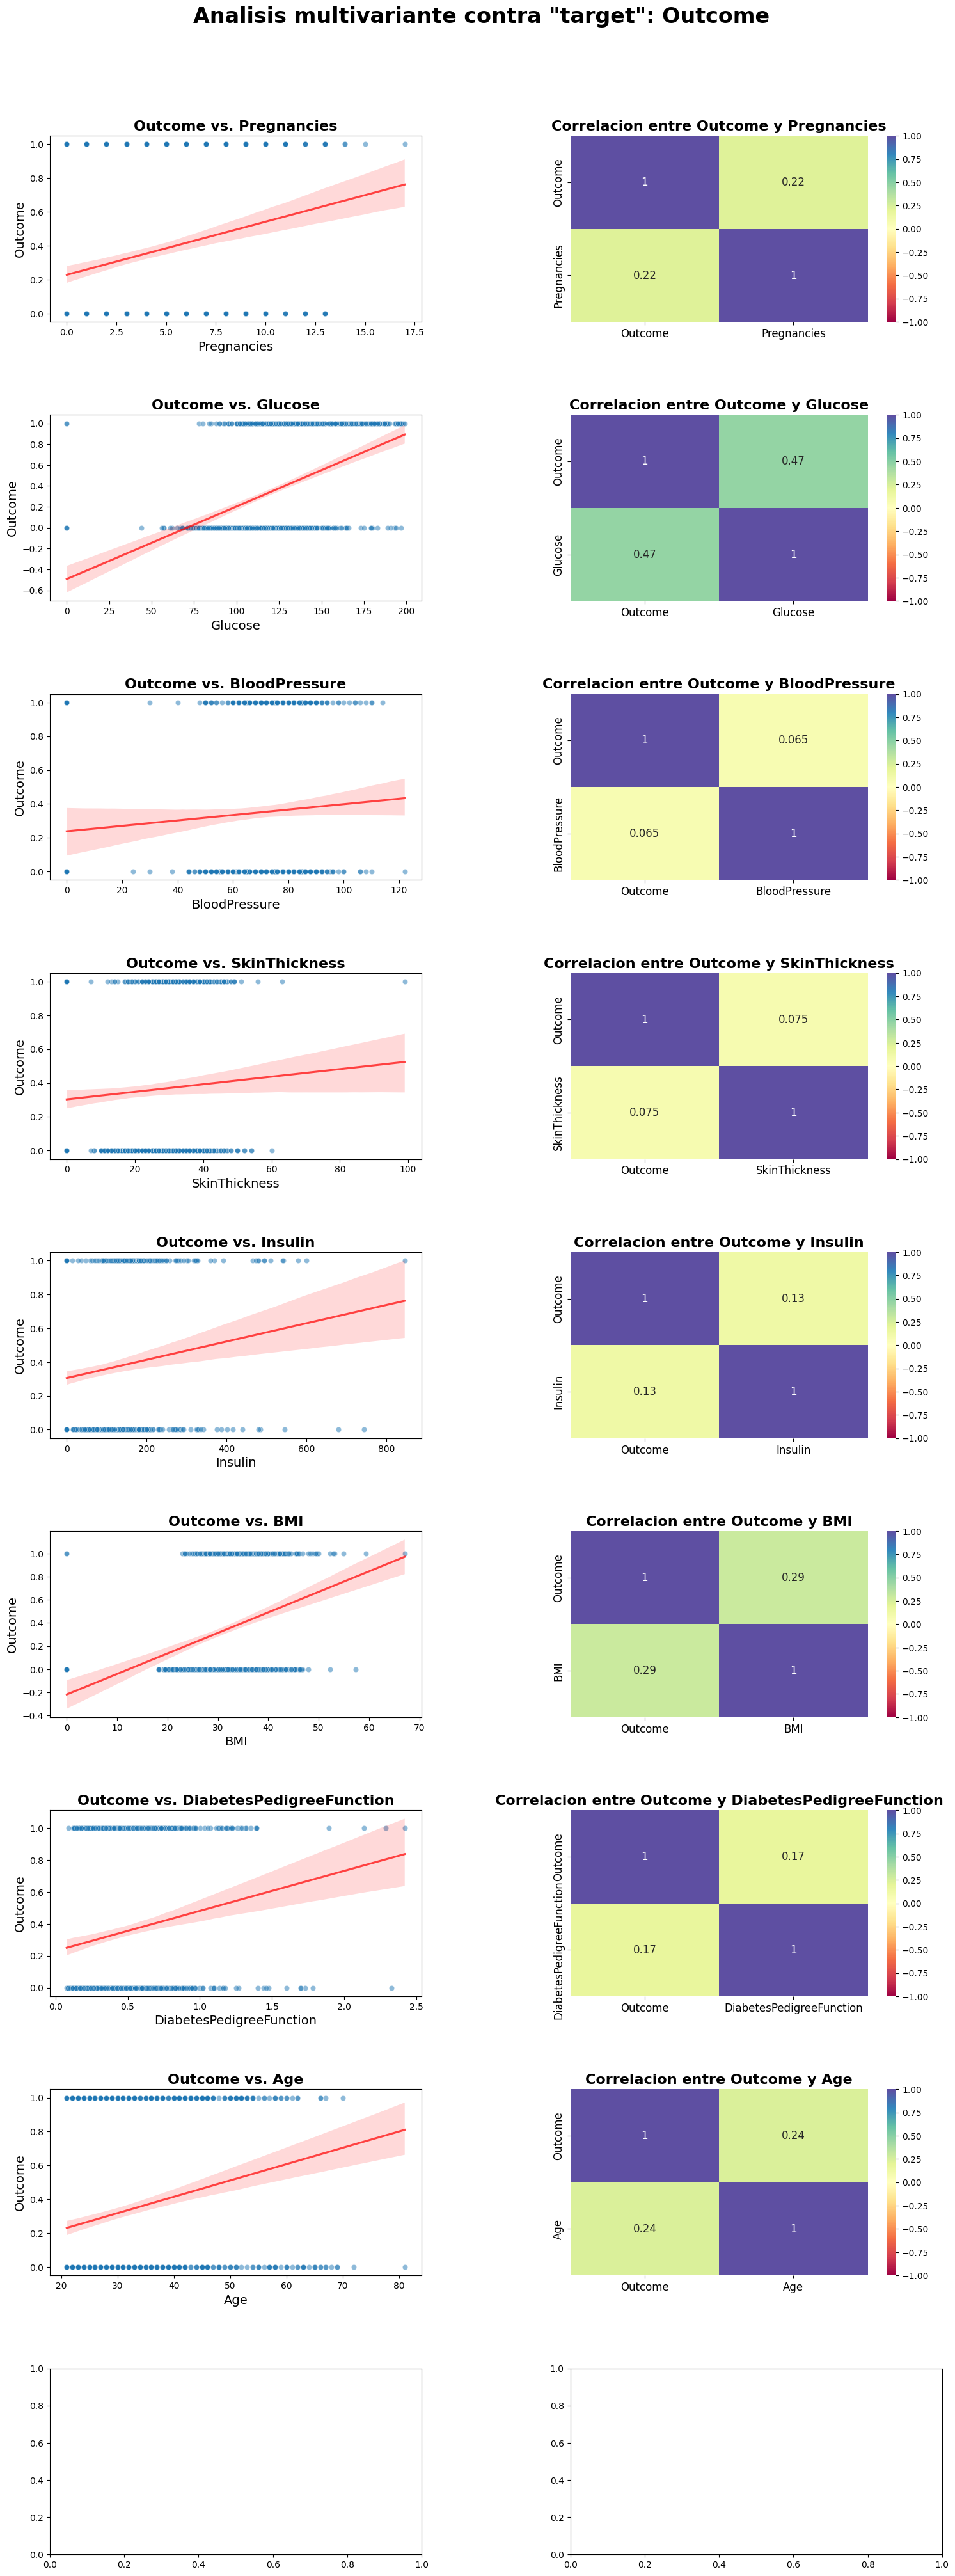

In [394]:
target = 'Outcome'
num_cols = df_eda.drop(columns=[target]).select_dtypes(include=["int64", "float64"]).columns.tolist()

fig, axes = plt.subplots(num_vars, 2, figsize=(18, num_vars * 5))
fig.suptitle(f'Analisis multivariante contra "target": {target}', fontsize=24, fontweight='bold', y=0.995)

for i, col in enumerate(num_cols):
    # Scatterplot con regresion lineal
    sns.scatterplot(ax=axes[i, 0], data=df_eda, x=col, y=target, alpha=0.5)
    sns.regplot(ax=axes[i, 0], data=df_eda, x=col, y=target, scatter=False, color='red', line_kws={"alpha":0.7})
    axes[i, 0].set_title(f'{target} vs. {col}', fontsize=16, fontweight='bold')
    axes[i, 0].set_xlabel(col, fontsize=14)
    axes[i, 0].set_ylabel(target, fontsize=14)
    
    # Matriz de correlacion entre la target y la variable numerica
    corr_data = df_eda[[target, col]].corr()
    sns.heatmap(ax=axes[i, 1], data=corr_data, annot=True, cmap='Spectral', cbar=True, vmin=-1, vmax=1, annot_kws={"size": 12})
    axes[i, 1].set_title(f'Correlacion entre {target} y {col}', fontsize=16, fontweight='bold')
    axes[i, 1].tick_params(axis='both', which='major', labelsize=12)

plt.subplots_adjust(top=0.95, hspace=0.5, wspace=0.4)
plt.show()


### Conclusiones del análisis multivariante (variables numéricas vs `Outcome`)

En este apartado analizamos la relación entre la variable objetivo `Outcome`
(0 = no diabetes, 1 = diabetes) y cada una de las variables numéricas, usando:

- Gráficos de dispersión con recta de regresión lineal.
- Matrices de correlación de Pearson `corr(Outcome, variable)`.

A nivel general:

- Una **pendiente positiva** en la recta roja indica que, a medida que aumenta
  la variable, **aumenta la probabilidad de `Outcome = 1`** (diabetes).
- Valores de correlación cercanos a 0 indican **poca relación lineal directa**,
  mientras que valores más altos (en valor absoluto) indican una relación más fuerte.

#### Pregnancies

- La pendiente de la recta es **ligeramente positiva**: a más embarazos,
  aumenta modestamente la probabilidad de diabetes.
- La correlación con `Outcome` es **baja pero positiva**.
- Intuición: el número de embarazos puede estar relacionado con cambios
  metabólicos a lo largo de la vida, pero no es una variable determinante por sí sola.

#### Glucose

- Es la variable con una relación más clara: la pendiente de la recta es
  **claramente positiva**.
- La correlación con `Outcome` es **moderada/alta y positiva**.
- Conclusión: **niveles más altos de glucosa** se asocian fuertemente con
  mayor probabilidad de diabetes. Es una de las variables clave que el modelo
  probablemente utilizará para separar clases.

#### BloodPressure

- La nube de puntos está bastante dispersa y la pendiente de la recta es
  cercana a **horizontal**.
- La correlación con `Outcome` es **muy baja**, prácticamente nula.
- Conclusión: la **presión arterial diastólica**, tal y como está medida en
  este dataset, **no parece ser un buen predictor lineal de diabetes**.
  Aun así, un árbol de decisión podría capturar algún efecto en ciertos
  rangos concretos.

#### SkinThickness

- Existe bastante dispersión y muchos valores alrededor de un rango limitado.
- La correlación con `Outcome` es **baja**, la recta tiene ligera pendiente
  positiva pero no muy marcada.
- Además, esta variable suele tener **muchos ceros o valores atípicos**, lo
  que puede estar reflejando problemas de medición o datos ausentes codificados
  como 0.
- Conclusión: por sí sola no muestra una relación lineal fuerte con diabetes.

#### Insulin

- La nube de puntos suele mostrar muchos valores en 0 y algunos valores muy
  altos, generando una distribución muy sesgada.
- La correlación con `Outcome` suele ser **positiva pero débil/moderada**.
- Debido a la cantidad de ceros, es probable que la calidad del dato no sea
  óptima y que el modelo tenga dificultades para extraer una señal clara
  sin un tratamiento previo (por ejemplo, imputando o transformando la variable).

#### BMI (Índice de masa corporal)

- La pendiente de la recta es **positiva**: a mayor BMI, mayor probabilidad
  de `Outcome = 1`.
- La correlación con `Outcome` es **moderada y positiva**.
- Conclusión: el **sobrepeso/obesidad** (BMI alto) se asocia con mayor
  riesgo de diabetes, y esta variable es probablemente importante para el modelo.

#### DiabetesPedigreeFunction

- La recta tiene una pendiente positiva, aunque no tan pronunciada como en
  el caso de `Glucose` o `BMI`.
- La correlación con la variable objetivo es **positiva, de magnitud baja
  a moderada**.
- Conclusión: el componente **genético / familiar** de riesgo de diabetes
  está presente, pero no es el factor dominante.

#### Age

- La pendiente es **positiva**: a mayor edad, aumenta la probabilidad
  de tener diabetes.
- La correlación con `Outcome` es **moderada**.
- Conclusión: la edad influye en el riesgo de diabetes, como era de esperar,
  aunque su efecto no es tan fuerte como el de `Glucose` o `BMI`.

---

### Implicaciones para el modelo de Árbol de Decisión

- Las variables que muestran una relación más clara con `Outcome` a nivel
  lineal son principalmente:
  - **Glucose**
  - **BMI**
  - **Age**
  - (en menor medida) **DiabetesPedigreeFunction** y **Pregnancies**.

- Variables como **BloodPressure**, **SkinThickness** e **Insulin** muestran
  correlaciones lineales débiles, pero un Árbol de Decisión podría seguir
  encontrando reglas útiles en ciertos rangos (por ejemplo, valores muy extremos).

- La matriz de correlaciones nos da una primera idea de qué variables serán
  más útiles en el modelo, pero:
  - No captura relaciones **no lineales**.
  - No tiene en cuenta **interacciones** entre variables (por ejemplo,
    combinaciones de edad y glucosa).

Por eso, en los siguientes pasos (entrenamiento del árbol y análisis de
`feature_importances_`) comprobaremos si estas intuiciones se confirman
y qué variables acaban siendo más importantes para la clasificación.

## 4.2 Matriz de Correlaciones

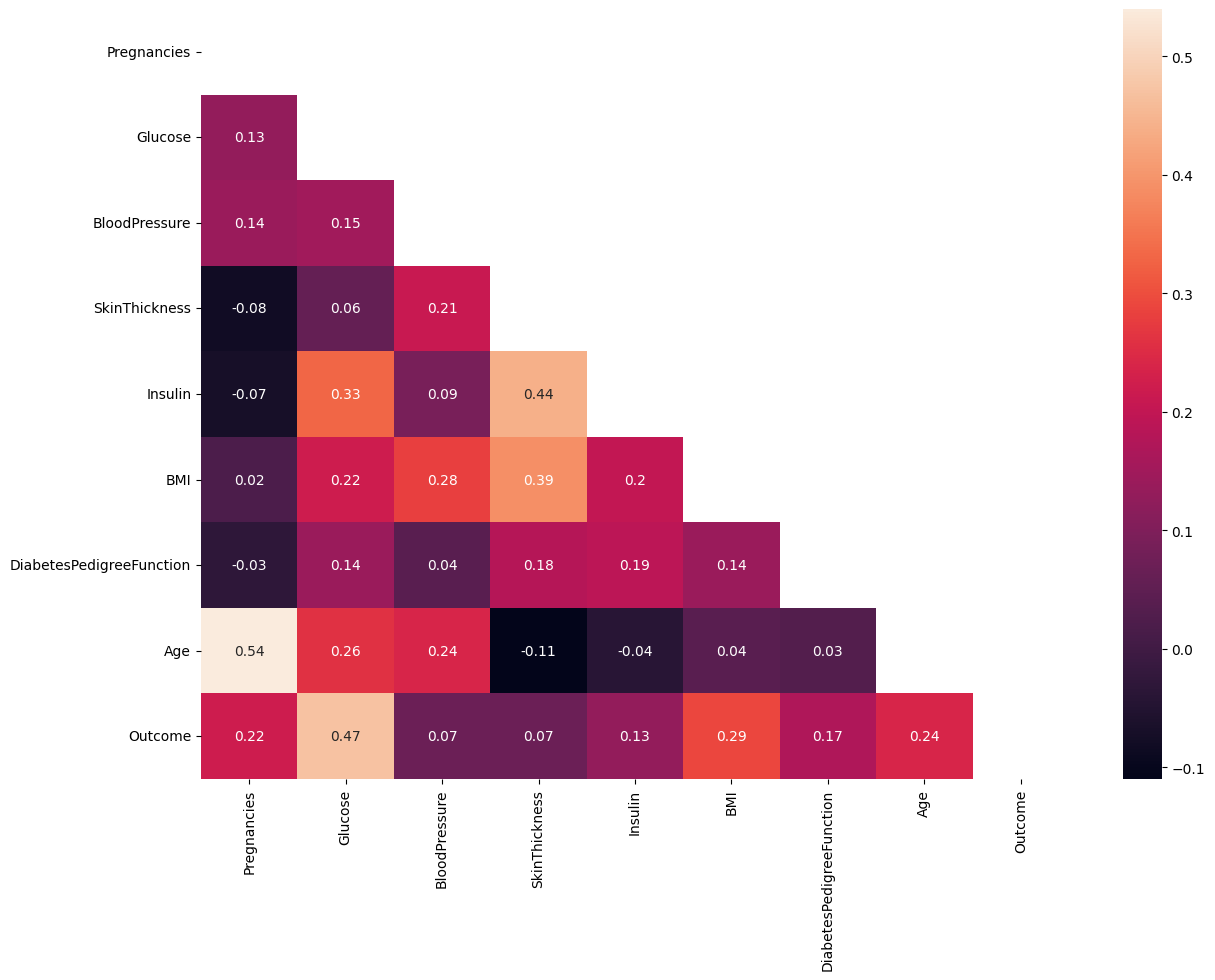

In [395]:
plt.figure(figsize=(14,10))
sns.heatmap(df_eda.corr().round(2), annot=True, mask=np.triu(df_eda.corr()))
plt.show()